In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from pandarallel import pandarallel
from tqdm.notebook import tqdm

tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count(logical=False))
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-69-g0be6d78-dirty (engine: v0.7.0-27-g5283549-dirty)
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: v0.7.0-27-g5283549-dirty


In [2]:
# Fix model import
import sys
import experiments.train.cfg_model as cfg_model

sys.modules[
    "cfg_model"
] = cfg_model  # cfg_model should be moved somewhere else, I guess

In [3]:
episode_len = 2048
n_episodes = 25
batches = [
    # "2023-01-10_tailstorm-8-constant",
    # "2023-01-11_nakamoto", # broken, is it because is was trained on python3.11?
    # "2023-01-11_bk-8",
    # "2023-01-12_nakamoto",
    # "2023-01-13_full",
    "2023-01-18_all-protos-0",
    "2023-01-19_nakamoto-0",
    "2023-01-19_all-protos-0",
    "2023-01-20_tailstorm-0",
    "2023-01-20_tailstorm-discount",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [4]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)
            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reuse="-")
models

,protocol,k,reward,subblock_selection,alpha,gamma,policy,path,kind,reuse
0,nakamoto,1,constant,n/a,0.45,0.05,ppo-exp-l0snb7rh-last,data/models/2023-01-18_all-protos-0/ppo-nakamo...,trained,-
1,bk,8,constant,n/a,0.35,0.50,ppo-cut-jtbk5801-best,data/models/2023-01-18_all-protos-0/ppo-bk-8-a...,trained,-
2,nakamoto,1,constant,n/a,0.45,0.05,ppo-raw-jxh7vrb1-last,data/models/2023-01-18_all-protos-0/ppo-nakamo...,trained,-
3,tailstorm,8,constant,heuristic,0.40,0.05,ppo-exp-3m3o72z0-last,data/models/2023-01-18_all-protos-0/ppo-tailst...,trained,-
4,tailstorm,8,constant,heuristic,0.35,0.50,ppo-exp-mjli3xrv-best,data/models/2023-01-18_all-protos-0/ppo-tailst...,trained,-
...,...,...,...,...,...,...,...,...,...,...
271,tailstorm,8,discount,heuristic,0.25,0.95,ppo-raw-1t5sf2q4-best,data/models/2023-01-20_tailstorm-discount/ppo-...,trained,-
272,tailstorm,8,discount,heuristic,0.40,0.05,ppo-exp-z2scdtx8-last,data/models/2023-01-20_tailstorm-discount/ppo-...,trained,-
273,tailstorm,8,discount,heuristic,0.40,0.50,ppo-exp-p77whmsa-last,data/models/2023-01-20_tailstorm-discount/ppo-...,trained,-
274,tailstorm,8,discount,heuristic,0.45,0.95,ppo-raw-p78rb1uw-best,data/models/2023-01-20_tailstorm-discount/ppo-...,trained,-


In [5]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reuse="proto", reward="discount"
        ),
        models.query("gamma != 0.05").assign(reuse="gamma05", gamma=0.05),
        models.query("gamma != 0.50").assign(reuse="gamma50", gamma=0.50),
        models.query("gamma != 0.95").assign(reuse="gamma95", gamma=0.95),
    ]
)
models = models.assign(reused=[x != "-" for x in models.reuse])
# models

## Find hard-coded policies

In [6]:
def hard_coded_policies(models):
    for _idx, x in models[
        ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
    ].iterrows():
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reused=False)
)
hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

,protocol,k,reward,subblock_selection,policy,kind,path,reused
0,nakamoto,1,constant,n/a,sapirshtein-2016-sm1,hard-coded,n/a,False
1,nakamoto,1,constant,n/a,eyal-sirer-2014,hard-coded,n/a,False
2,nakamoto,1,constant,n/a,simple,hard-coded,n/a,False
3,nakamoto,1,constant,n/a,honest,hard-coded,n/a,False
4,bk,8,constant,n/a,selfish,hard-coded,n/a,False
5,bk,8,constant,n/a,honest,hard-coded,n/a,False
10,tailstorm,8,constant,heuristic,override-catchup,hard-coded,n/a,False
11,tailstorm,8,constant,heuristic,override-block,hard-coded,n/a,False
12,tailstorm,8,constant,heuristic,release-block,hard-coded,n/a,False
13,tailstorm,8,constant,heuristic,honest,hard-coded,n/a,False


## Run simulations

In [7]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)


def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


d = episodes.sample(
    frac=1
)  # shuffle for better load balancing in case of cached measurements

# results = d.progress_apply(measure_row, axis=1)
with threadpoolctl.threadpool_limits(limits=1):
    results = d.parallel_apply(measure_row, axis=1)

episodes = pd.concat([d, results], axis=1).sort_index()

# list(episodes.columns)

# Find optimal policies

In [8]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

,protocol,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
0,bk,8,constant,n/a,0.35,0.05,hard-coded,False,honest
1,bk,8,constant,n/a,0.35,0.05,trained,False,ppo-raw-9htkur3m-last
2,bk,8,constant,n/a,0.35,0.05,trained,True,ppo-cut-1m4kn6s1-last
3,bk,8,constant,n/a,0.35,0.50,hard-coded,False,honest
4,bk,8,constant,n/a,0.35,0.50,trained,False,ppo-raw-kywnaryy-last
...,...,...,...,...,...,...,...,...,...
127,tailstorm,8,discount,heuristic,0.45,0.50,trained,False,ppo-exp-sqmbf0fn-last
128,tailstorm,8,discount,heuristic,0.45,0.50,trained,True,ppo-raw-bw5fuebk-best
129,tailstorm,8,discount,heuristic,0.45,0.95,hard-coded,False,override-block
130,tailstorm,8,discount,heuristic,0.45,0.95,trained,False,ppo-cut-i4ho85tu-best


# Compare RL against best hard-coded

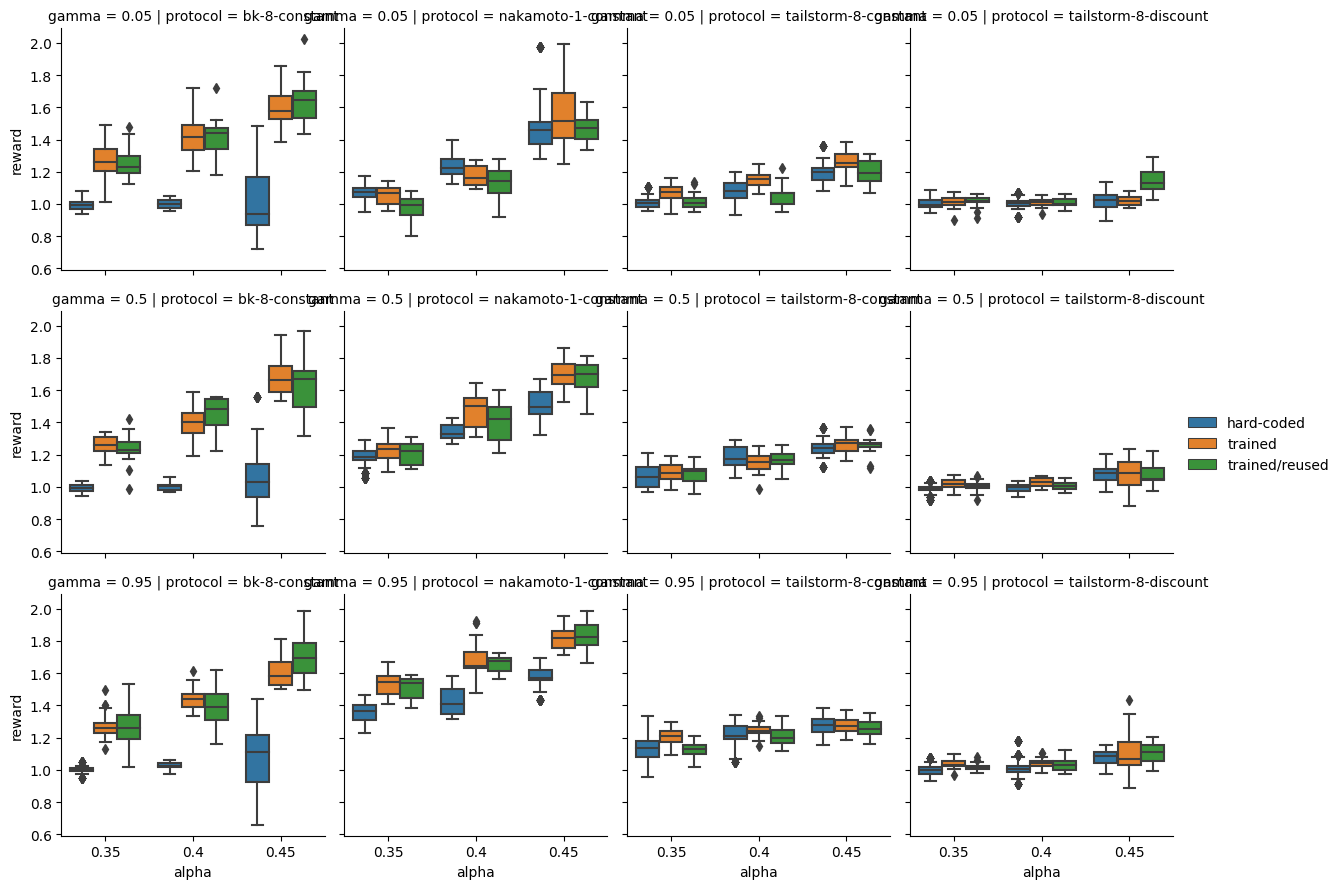

In [18]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

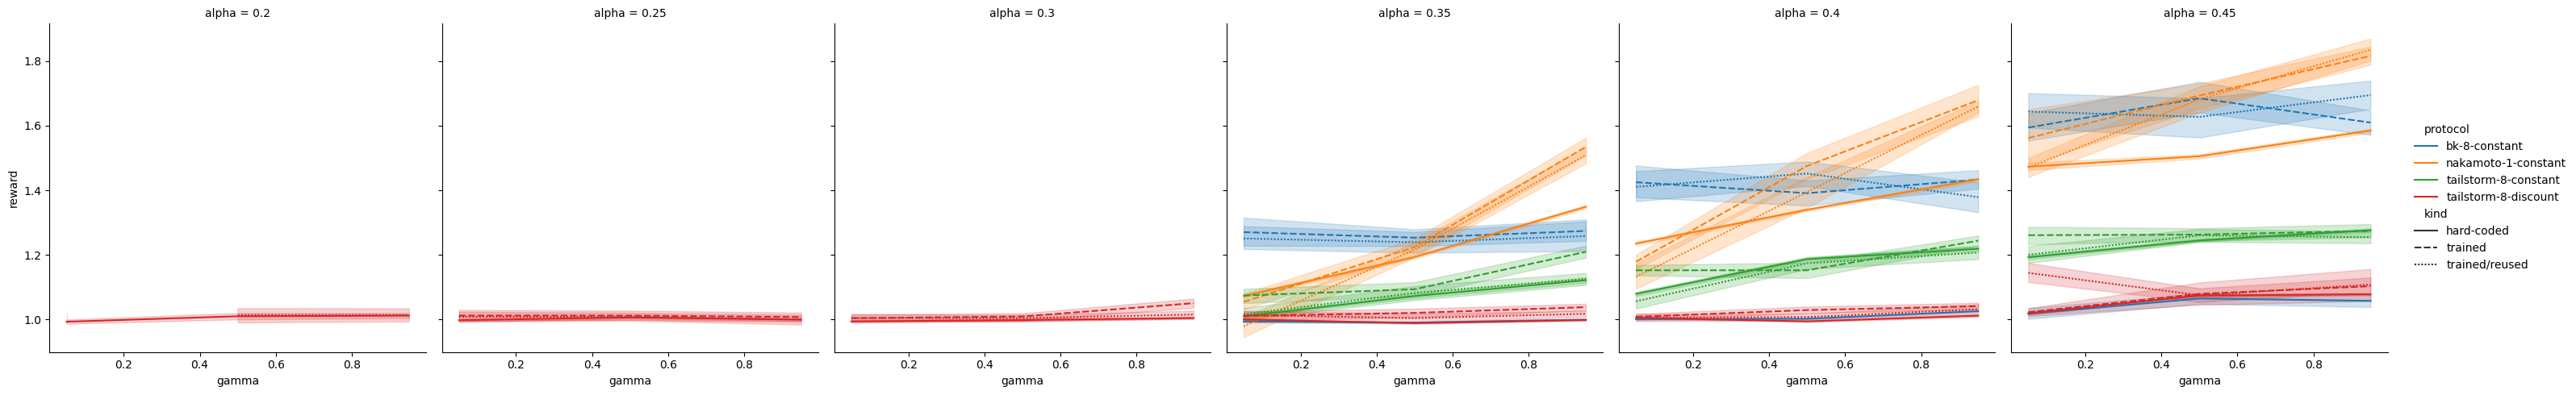

In [10]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

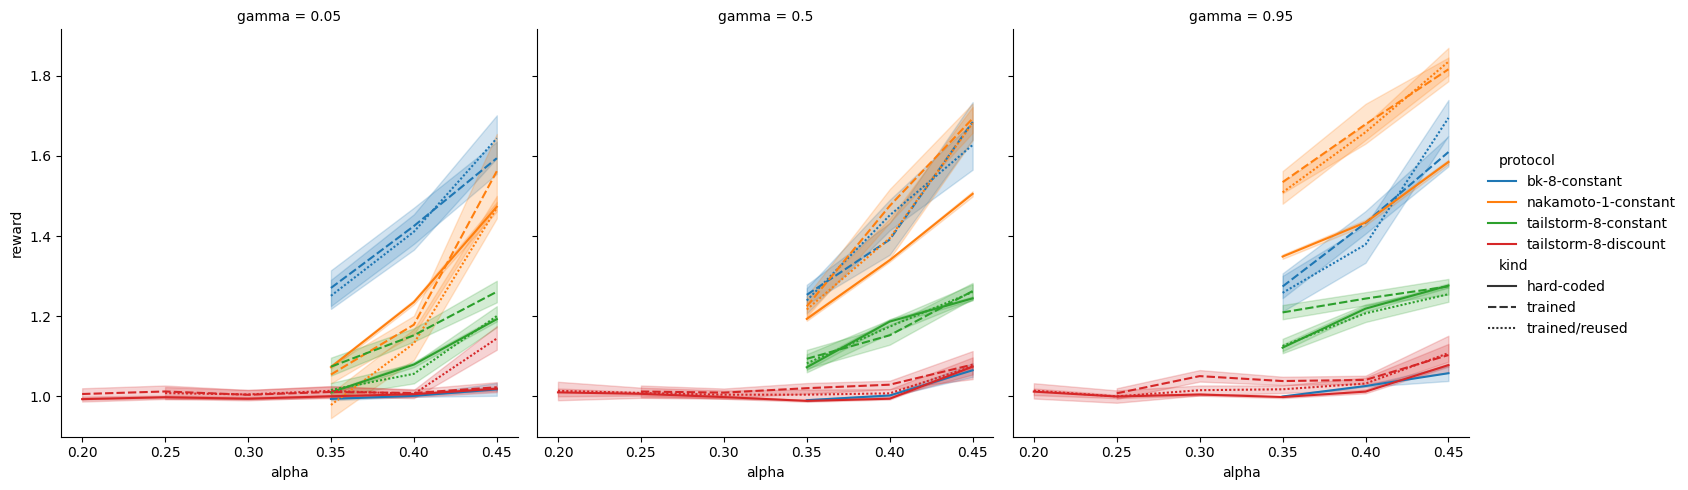

In [11]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

# Honest or Attack?

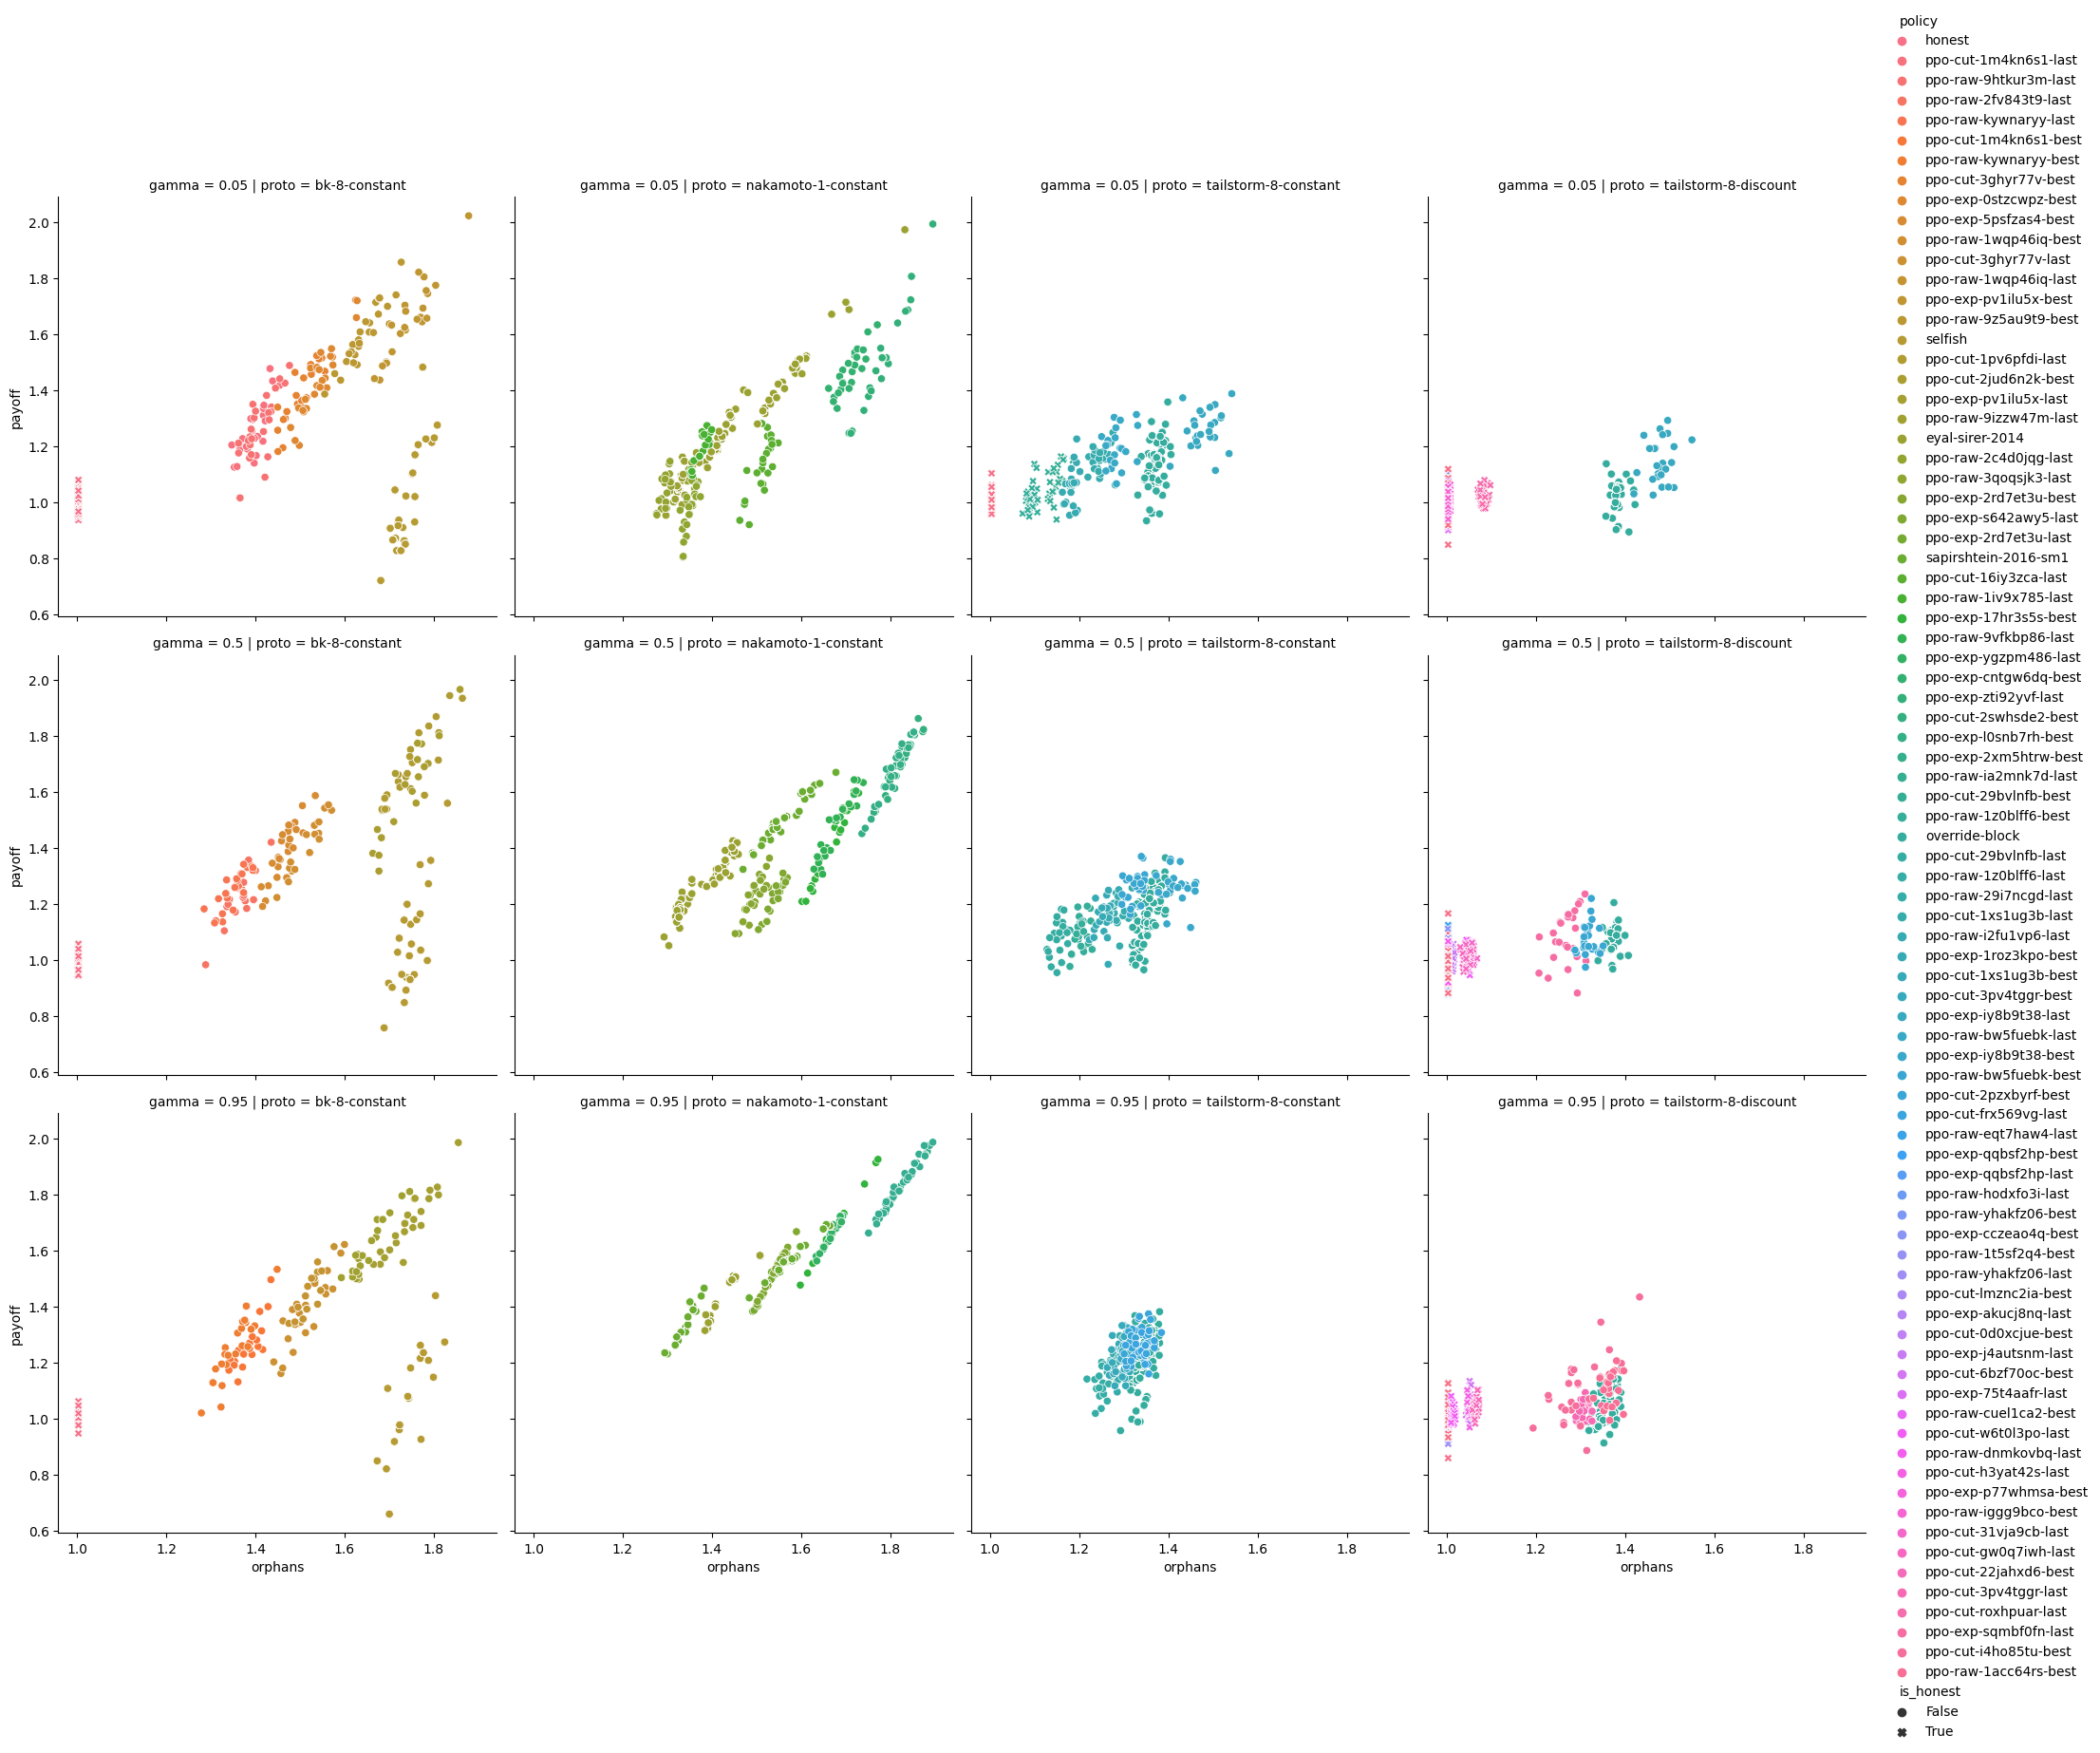

In [12]:
grouping = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "policy"]
d = opt_episodes.copy()
d["orphans"] = d.episode_n_activations / d.episode_progress
d["proto"] = d.protocol + "-" + d.k.map(str) + "-" + d.reward
d["payoff"] = d.episode_reward_attacker / d.episode_progress / d.alpha
dd = d.groupby(grouping).agg(
    mean_orphans=("orphans", "mean"),
    mean_payoff=("payoff", "mean"),
    std_payoff=("payoff", "std"),
)
d = d.set_index(grouping + ["episode"]).join(dd).reset_index()
d["is_honest"] = d.mean_orphans <= 1.15
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="policy",
    style="is_honest",
    row="gamma",
    col="proto",
)
honest_or_attack_episodes = d  # for later use
# list(d.columns)

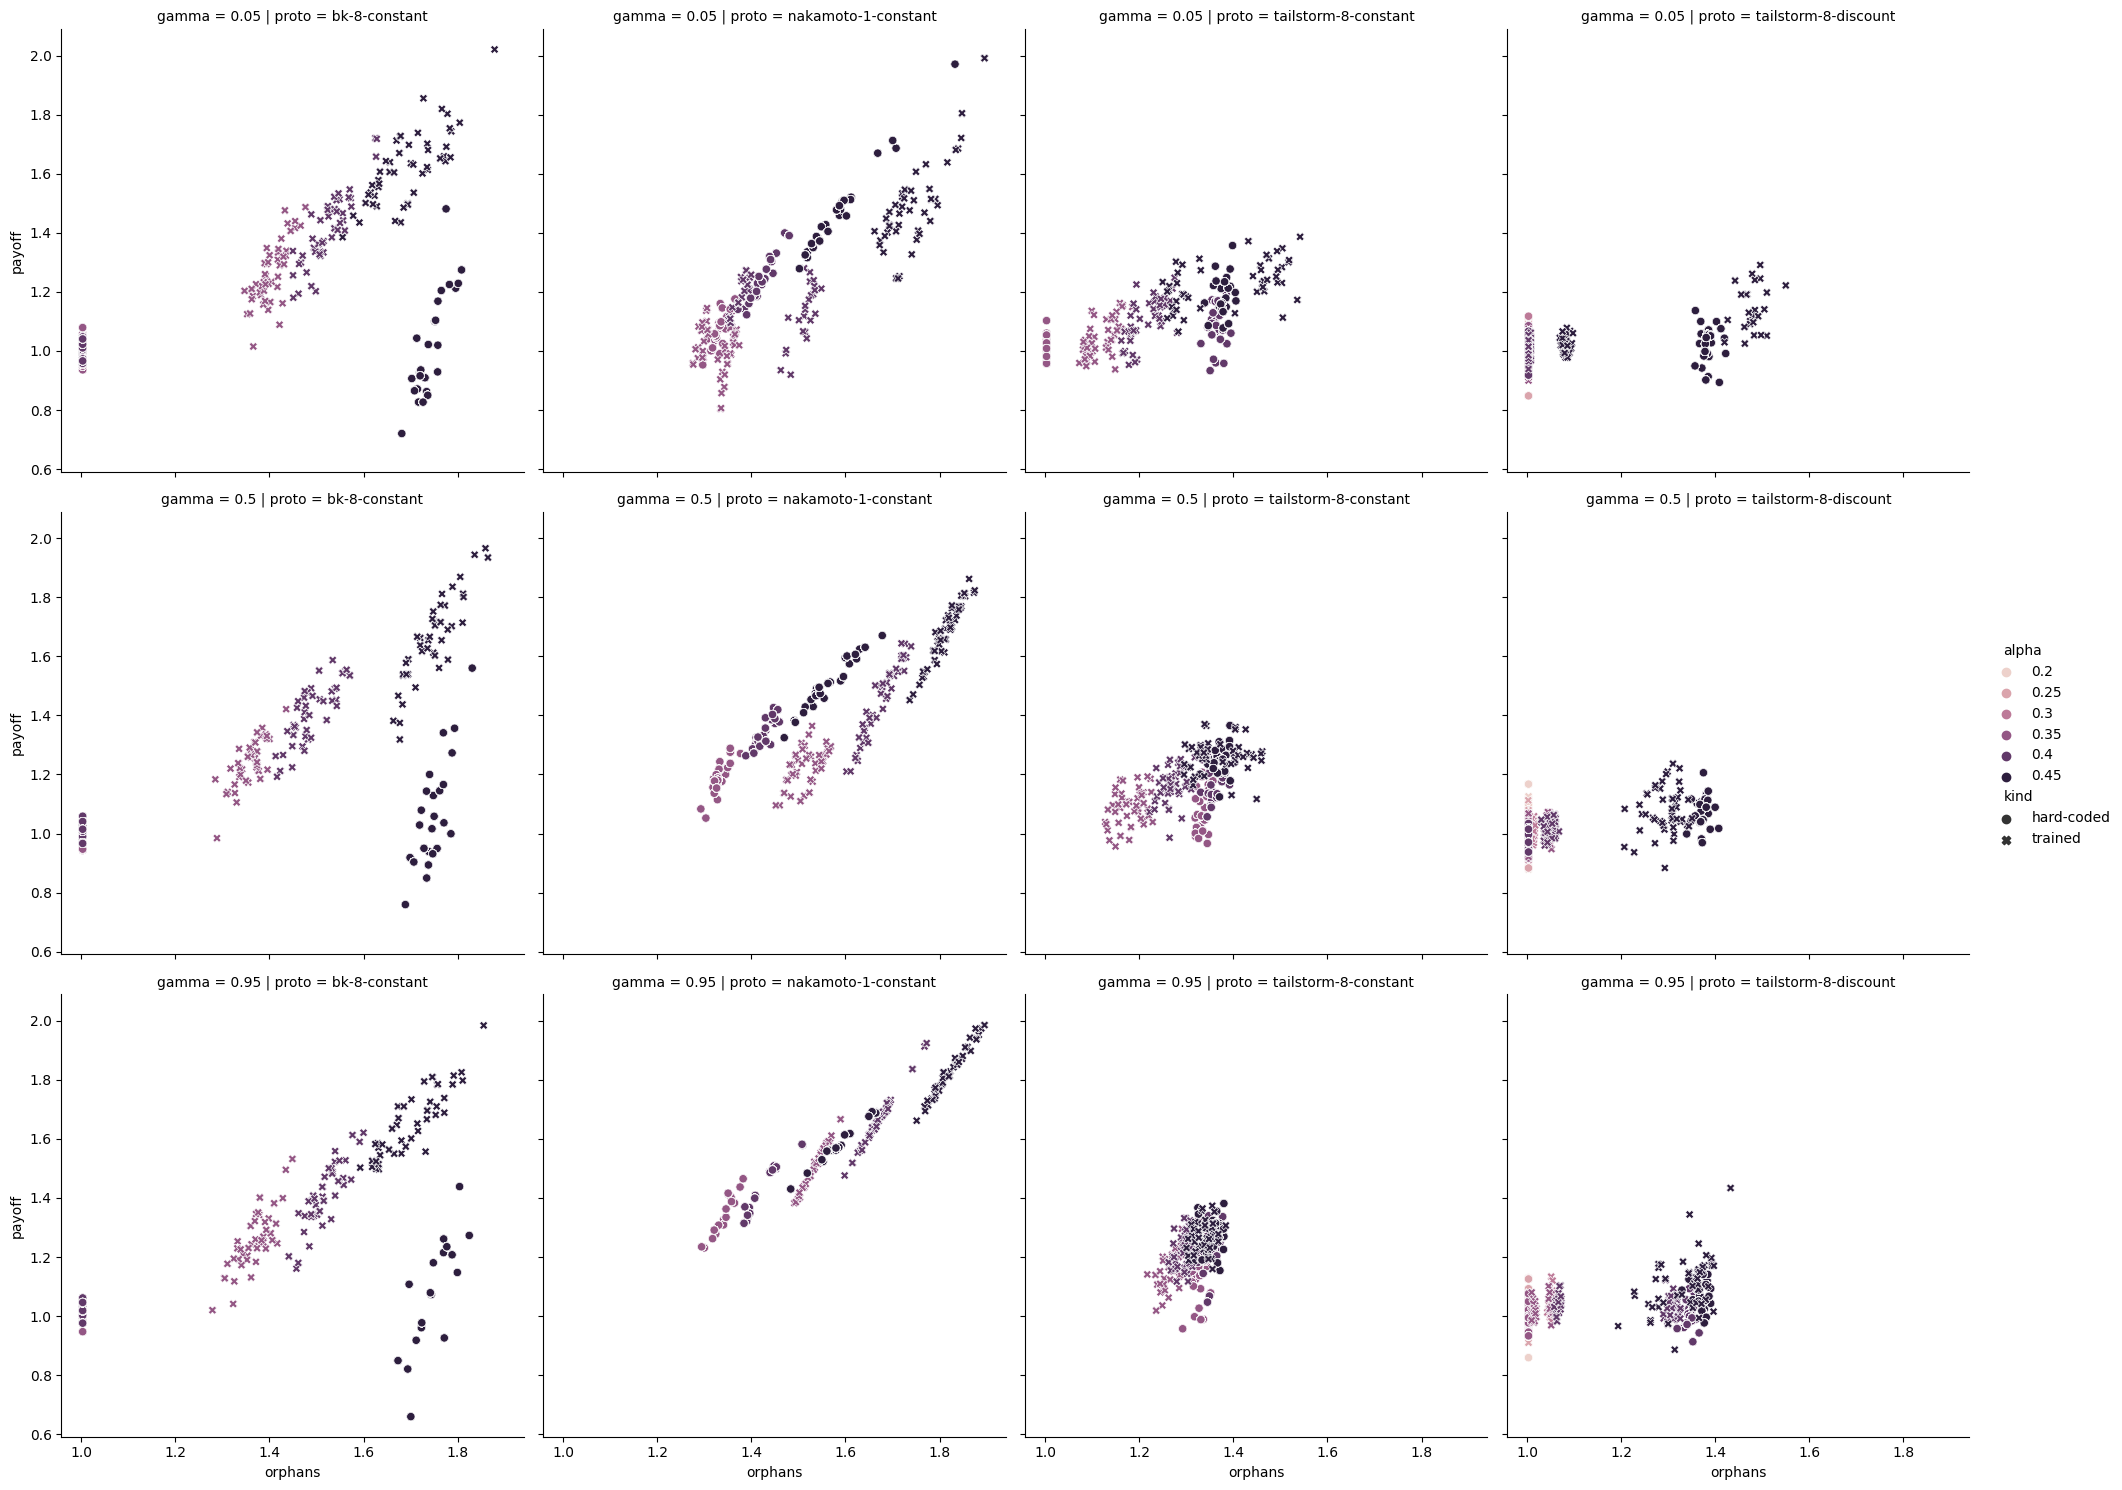

In [13]:
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

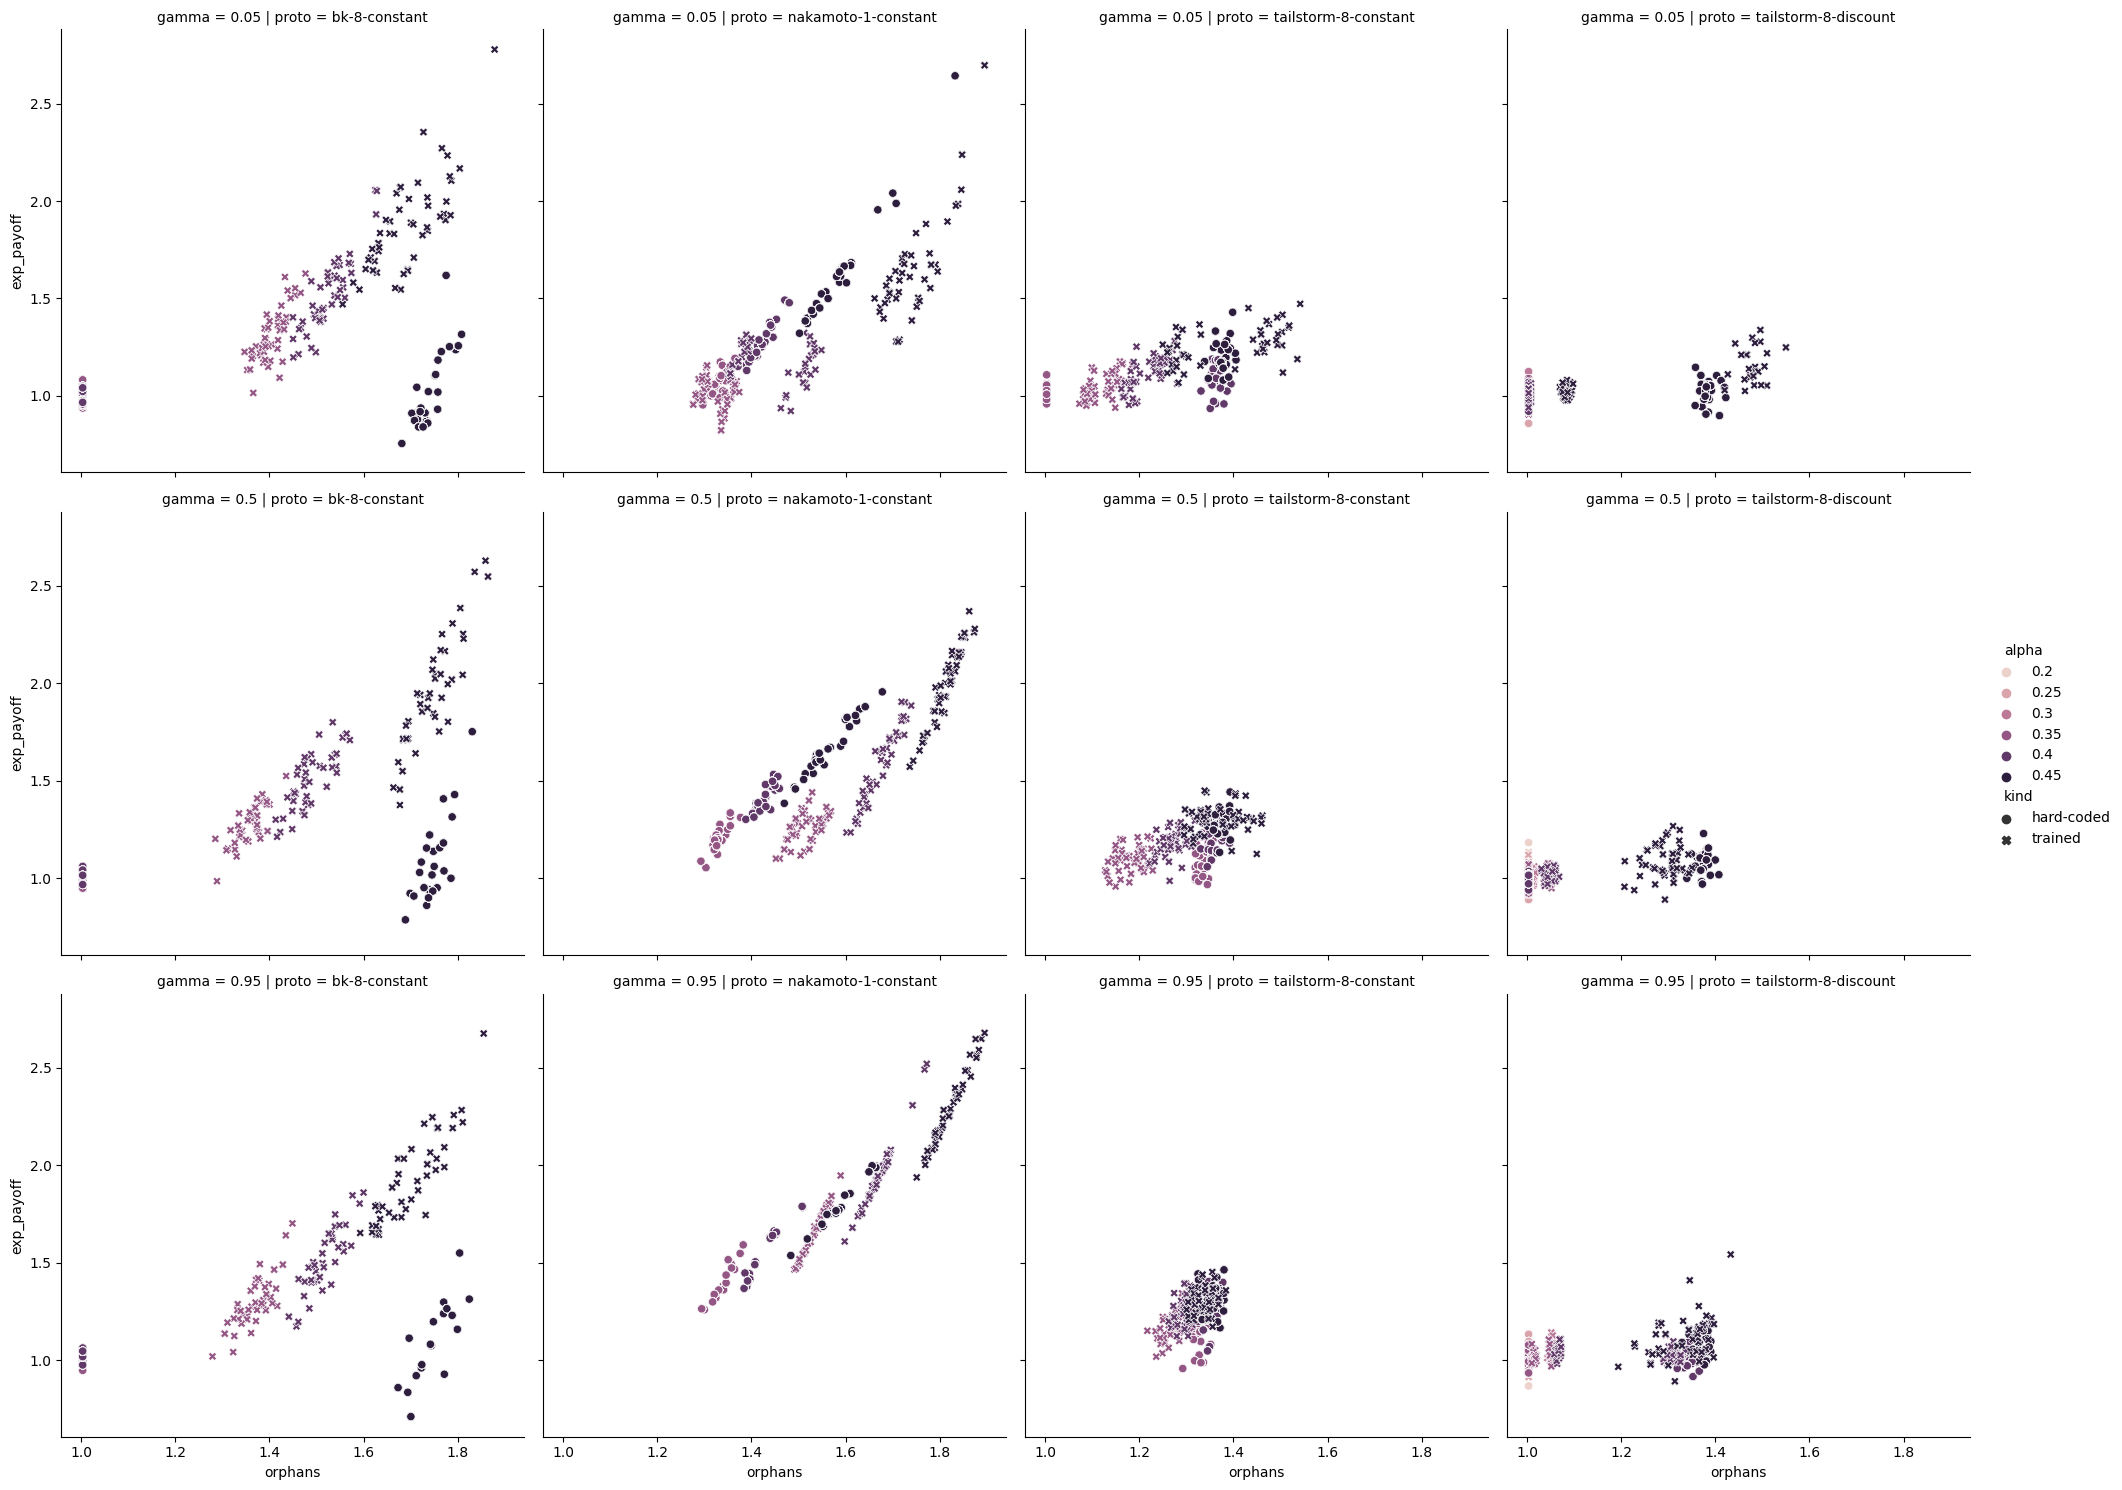

In [14]:
sns.relplot(
    data=d.assign(exp_payoff=np.exp(d.payoff - 1)),
    x="orphans",
    y="exp_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

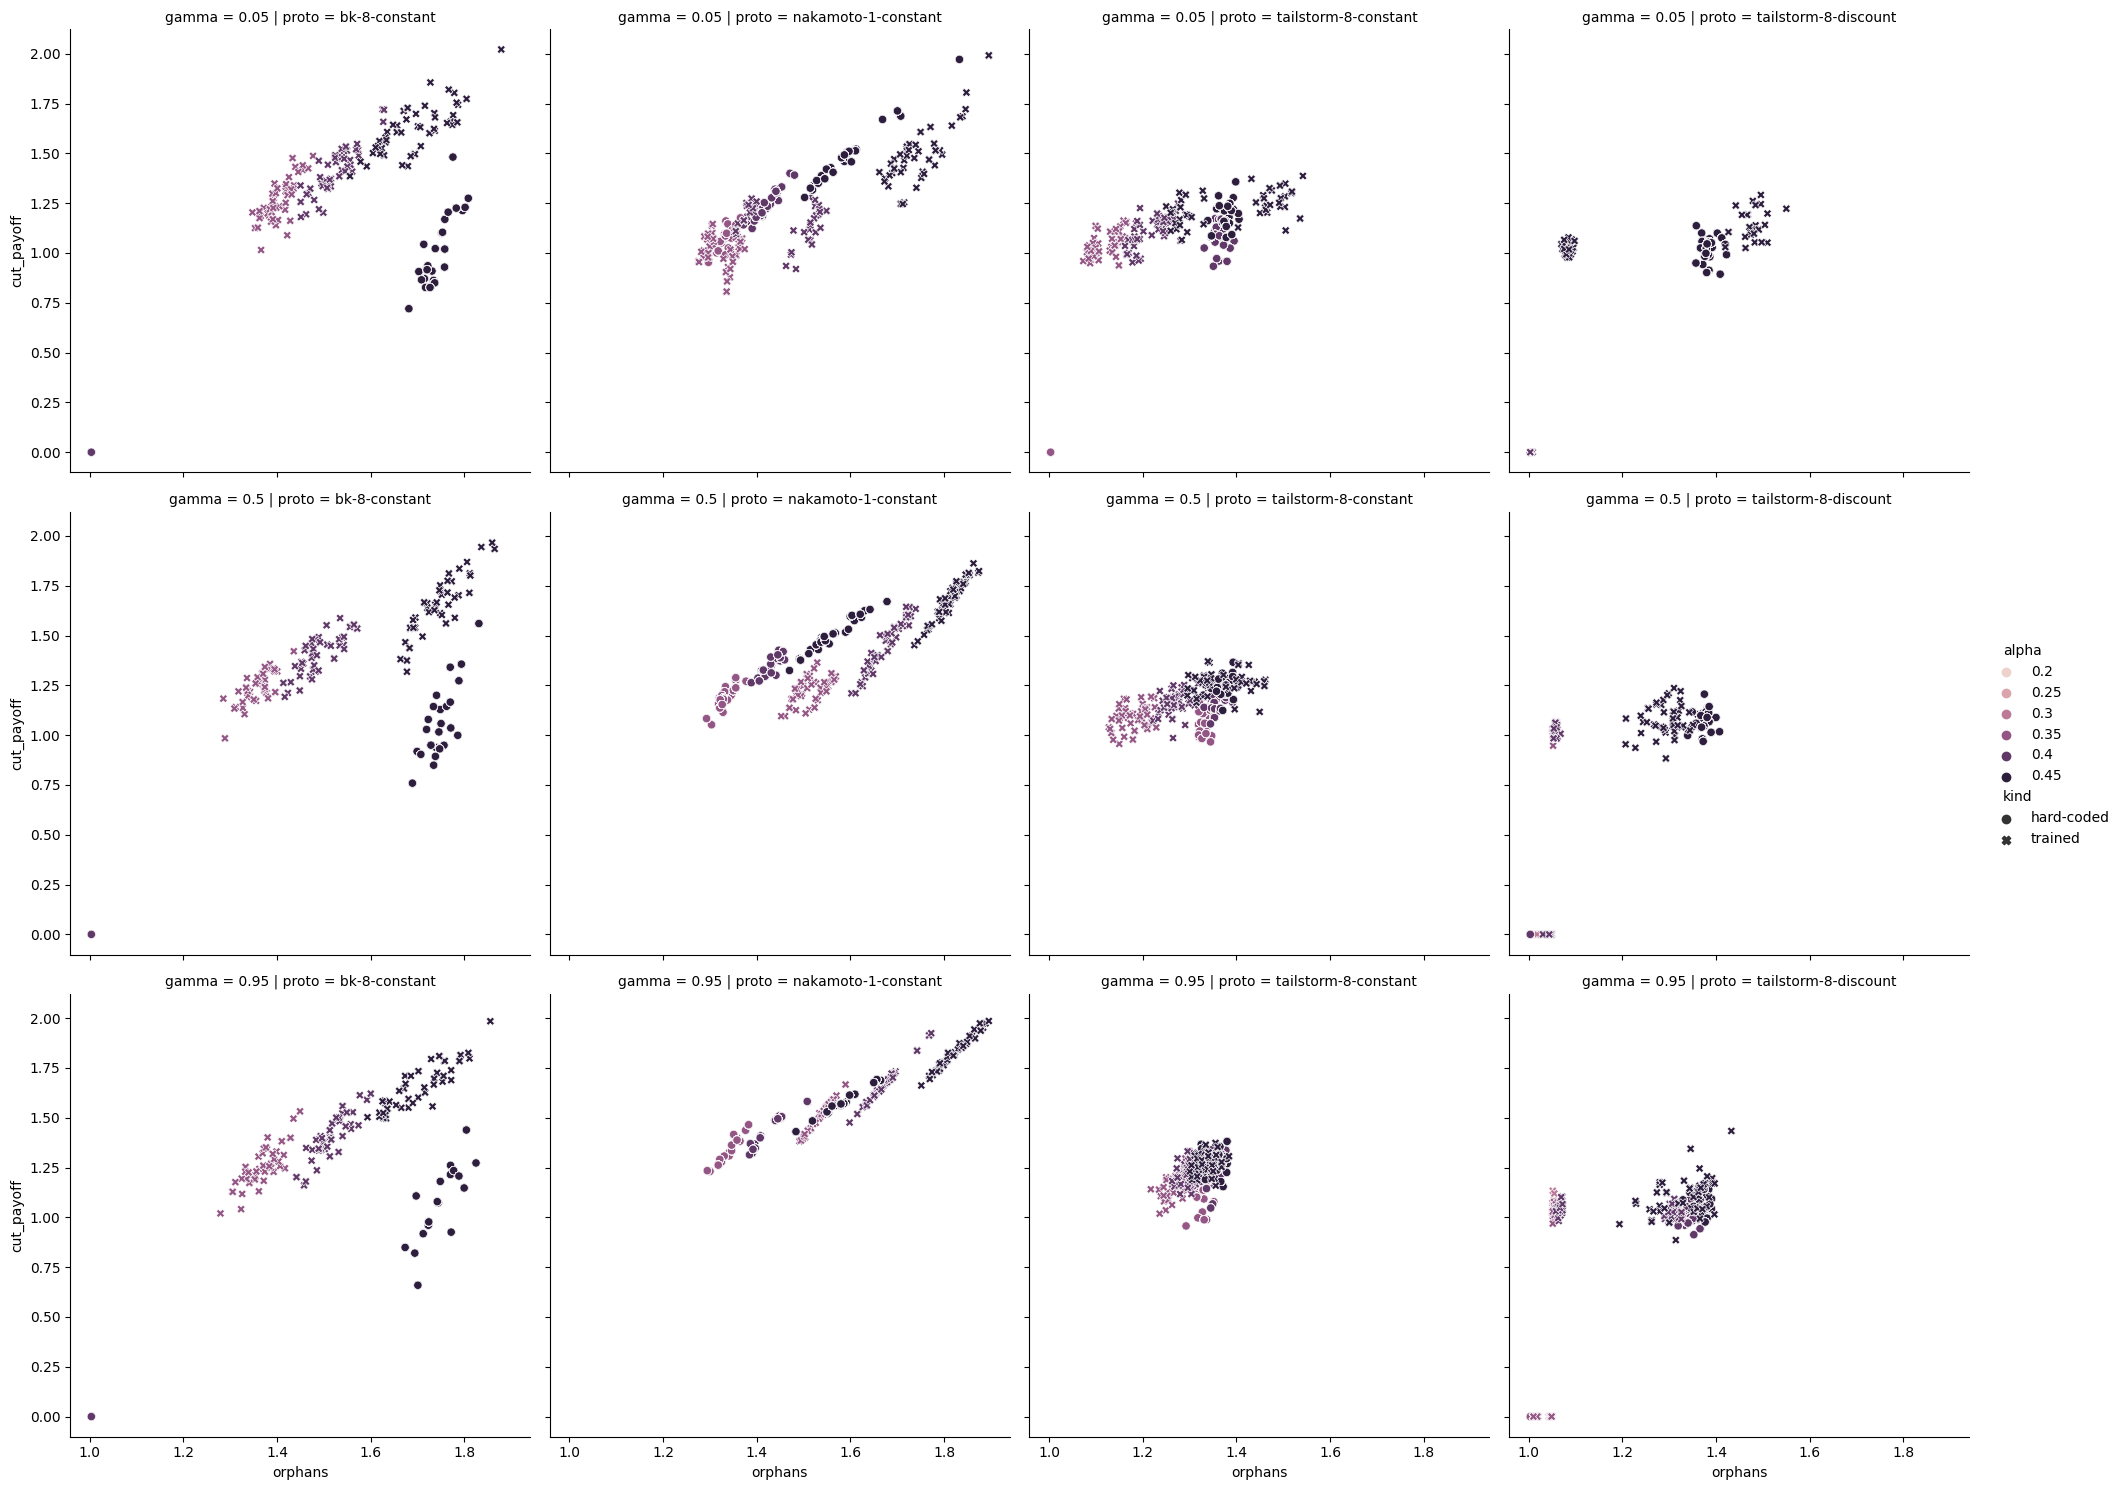

In [15]:
sns.relplot(
    data=d.assign(
        cut_payoff=[x.payoff if x.orphans > 1.05 else 0 for _, x in d.iterrows()]
    ),
    x="orphans",
    y="cut_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [16]:
grouping = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
select = ["policy", "reused", "path"]
d = honest_or_attack_episodes.query("is_honest == False and reused=False")
d = d[grouping + ["alpha"] + select].drop_duplicates().reset_index(drop=True)
d = d.loc[d.groupby(grouping).alpha.idxmin()].reset_index(drop=True)
be_policies = d
display(be_policies.drop(columns="path"))

SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

In [ ]:
import break_even


def find_break_even_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = 8192  # quality of each point
    kwargs["n_calls"] = 42  # how many points
    kwargs[
        "title"
    ] = f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    if x.kind == "trained":
        res = break_even.find_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = break_even.find_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[2]]
d = be_policies

# results = d.progress_apply(find_break_even_row, axis = 1)
with threadpoolctl.threadpool_limits(limits=1):
    results = d.parallel_apply(find_break_even_row, axis=1)
be_points = pd.concat([d, results], axis=1)

In [ ]:
be_points.drop(columns=["path", "break_even_png"])

In [ ]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    kind="line",
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

In [ ]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)